Train the LSTM model on the train dataset split using the custom QRS-loss.

In [ ]:
from localdataset.dataset import LocalDataset
import torch
from typing import Tuple, List
import numpy as np
from sys import maxsize

from os import makedirs
from pathlib import Path

from tqdm import tqdm

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")


import holoviews as hv
hv.extension('bokeh')

In [2]:
num_memory_build = 500
num_predictions = 400

bidirectional = True

lstm_hidden_size= 300
num_lstm_layers = 5

epochs = 100
batch_size = 150

learning_rate = 0.00001

In [3]:
ds = LocalDataset()

In [4]:
mission_data_raw = ds.get_mission("49df9ae5-abec-4b26-8519-730680afc910").data

In [5]:
mission_data = mission_data_raw[83000:83000+10000+num_memory_build+num_predictions]

In [6]:
hv.Curve(mission_data).opts(height=400,width=700)

:Curve   [x]   (y)

In [7]:
import neurokit2 as nk

In [8]:
_, rpeaks = nk.ecg_peaks(mission_data, sampling_rate=300)

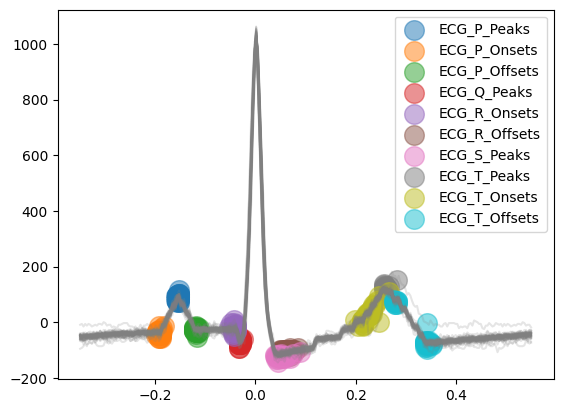

In [9]:
signal, waves = nk.ecg_delineate(mission_data, rpeaks, sampling_rate=300, method="dwt", show=True, show_type='all')

In [23]:
waves.keys()

dict_keys(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets'])

In [18]:
hv.opts.defaults(hv.opts.Points(size=7))
(hv.Curve(mission_data, label="mission") * hv.Points([(i, mission_data[i]) for i in waves["ECG_P_Peaks"]], label="p-peaks") * hv.Points([(i, mission_data[i]) for i in waves["ECG_Q_Peaks"] if i > 0], label="q-peaks") * hv.Points([(i, mission_data[i]) for i in waves["ECG_S_Peaks"] if i > 0], label="s-peaks") * hv.Points([(i, mission_data[i]) for i in waves["ECG_T_Peaks"] if i > 0], label="t-peaks") * hv.Points([(i, mission_data[i]) for i in rpeaks["ECG_R_Peaks"].tolist() if i > 0], label="ECG_R_Peaks")).opts(height=400,width=800)

:Overlay
   .Curve.Mission               :Curve   [x]   (y)
   .Points.P_hyphen_minus_peaks :Points   [x,y]
   .Points.Q_hyphen_minus_peaks :Points   [x,y]
   .Points.S_hyphen_minus_peaks :Points   [x,y]
   .Points.T_hyphen_minus_peaks :Points   [x,y]
   .Points.ECG_R_Peaks          :Points   [x,y]

In [19]:
import matplotlib.pyplot as plt

In [28]:
[(i, mission_data[i]) for i in waves["ECG_P_Peaks"] if i > 0]

[(153, 89.32000000000001),
 (402, 92.4),
 (653, 89.32000000000001),
 (904, 83.16),
 (1154, 77.0),
 (1405, 89.32000000000001),
 (1655, 80.08),
 (1906, 77.0),
 (2156, 89.32000000000001),
 (2407, 77.0),
 (2658, 83.16),
 (2909, 86.24000000000001),
 (3159, 92.4),
 (3409, 95.48),
 (3659, 80.08),
 (3911, 95.48),
 (4161, 73.92),
 (4411, 92.4),
 (4662, 98.56),
 (4913, 101.64),
 (5163, 77.0),
 (5414, 101.64),
 (5664, 89.32000000000001),
 (5915, 98.56),
 (6165, 98.56),
 (6415, 89.32000000000001),
 (6667, 89.32000000000001),
 (6917, 89.32000000000001),
 (7167, 89.32000000000001),
 (7418, 95.48),
 (7669, 89.32000000000001),
 (7919, 89.32000000000001),
 (8170, 95.48),
 (8420, 70.84),
 (8671, 98.56),
 (8922, 89.32000000000001),
 (9172, 101.64),
 (9422, 92.4),
 (9673, 101.64),
 (9924, 83.16),
 (10174, 113.96000000000001),
 (10425, 73.92),
 (10675, 83.16)]

In [75]:
mayor_points = [i for i in waves["ECG_P_Peaks"] + waves["ECG_Q_Peaks"] + waves["ECG_S_Peaks"] + waves["ECG_T_Peaks"] if i > 0] + rpeaks["ECG_R_Peaks"].tolist()

### demo loss function

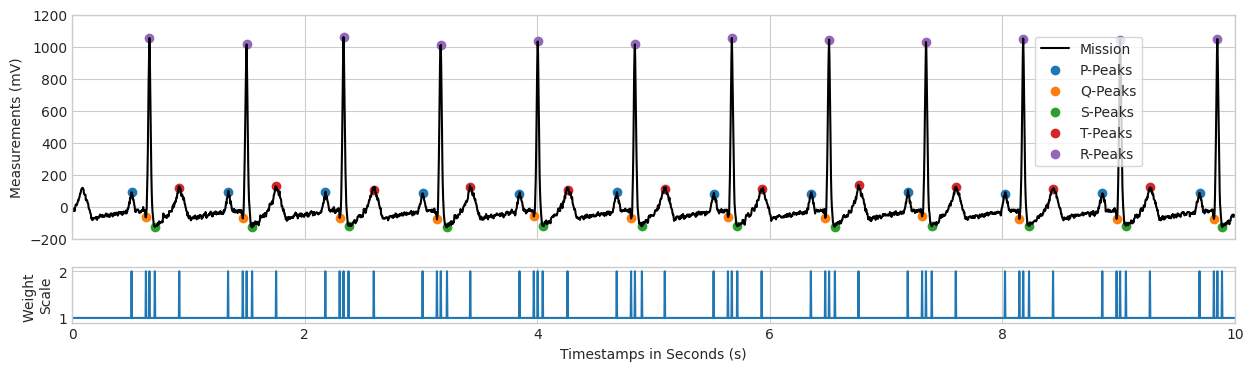

In [102]:

plt.style.use('seaborn-v0_8-whitegrid')

fig, (ax, ax2) = plt.subplots(2, sharex='col', gridspec_kw={'height_ratios': [4, 1]}, figsize=(15,4))
# fig = plt.figure(figsize=(15,4))
# ax = fig.add_subplot(111)

m, = ax.plot(mission_data, color="black", label="Mission")

p = ax.scatter(*list(zip(*[(i, mission_data[i]) for i in waves["ECG_P_Peaks"] if i > 0])), label="P-Peaks")
q = ax.scatter(*list(zip(*[(i, mission_data[i]) for i in waves["ECG_Q_Peaks"] if i > 0])), label="Q-Peaks")
s = ax.scatter(*list(zip(*[(i, mission_data[i]) for i in waves["ECG_S_Peaks"] if i > 0])), label="S-Peaks")
t = ax.scatter(*list(zip(*[(i, mission_data[i]) for i in waves["ECG_T_Peaks"] if i > 0])), label="T-Peaks")
r = ax.scatter(*list(zip(*[(i, mission_data[i]) for i in rpeaks["ECG_R_Peaks"] if i > 0])), label="R-Peaks")


# add weights 
# ax2 = fig.add_subplot(211)

# ax2 = ax.twinx()
weight_line = np.ones(mission_data.shape[0])
for i in mayor_points:
    weight_line[i] += 1
ax2.plot(weight_line, label="Weights")

ax.set_xlim(0, 300*10)
ax2.set_ylim(0.9, 2.1)
ax2.set_ylabel("Weight \nScale")


ax2.set_xlabel("Timestamps in Seconds (s)")
ax.set_ylabel("Measurements (mV)")

ax.set_xlim(0, 300*10)
ax.set_ylim(-200, 1200)

ax.set_xticks([i*300*2 for i in range(6)], [i*2 for i in range(6)])

fig.legend(handles=[m, p, q, s, t, r], loc=(0.826, 0.55), frameon = True, facecolor="white") #, l3, l4
fig.show()
fig.savefig("images/qrs_detection_demo.png", dpi=1000)